In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


import cv2
import random
import shutil
import zipfile
import time
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt

print("\nProje için tüm kütüphaneler başarıyla import edildi.")

/kaggle/input/dogs-vs-cats/test1.zip
/kaggle/input/dogs-vs-cats/train.zip
/kaggle/input/dogs-vs-cats/sampleSubmission.csv


2025-09-19 00:39:26.740877: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758242366.934804      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758242366.988809      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered



Proje için tüm kütüphaneler başarıyla import edildi.


In [2]:
# Hasar efekti fonksiyonlarını tanımla

def apply_wrinkle_effect(image):
    rows, cols, _ = image.shape
    x_map, y_map = np.zeros((rows, cols), np.float32), np.zeros((rows, cols), np.float32)
    frequency, amplitude = np.random.uniform(5, 10), np.random.uniform(10, 20)
    for i in range(rows):
        for j in range(cols):
            x_map[i, j] = j + amplitude * np.cos(2 * np.pi * i / (rows / frequency))
            y_map[i, j] = i + amplitude * np.sin(2 * np.pi * j / (cols / frequency))
    return cv2.remap(image, x_map, y_map, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REPLICATE)

def apply_stain_effect(image):
    stained_image = image.copy()
    rows, cols, _ = image.shape
    center_x, center_y = np.random.randint(0, cols), np.random.randint(0, rows)
    radius = np.random.randint(int(cols/10), int(cols/4))
    color, alpha = (33, 67, 101), 0.4 # BGR formatında kahverengi ve şeffaflık
    overlay = stained_image.copy()
    cv2.circle(overlay, (center_x, center_y), radius, color, -1)
    cv2.addWeighted(overlay, alpha, stained_image, 1 - alpha, 0, stained_image)
    return stained_image

def apply_tear_effect(image):
    torn_image = image.copy()
    rows, cols, _ = image.shape
    tear_x, tear_y = np.random.randint(int(cols/4), int(cols/2)), np.random.randint(int(rows/4), int(rows/2))
    corner = np.random.randint(0, 4)
    if corner == 0: pts = np.array([[0, 0], [tear_x, 0], [0, tear_y]], np.int32)
    elif corner == 1: pts = np.array([[cols, 0], [cols - tear_x, 0], [cols, tear_y]], np.int32)
    elif corner == 2: pts = np.array([[0, rows], [0, rows - tear_y], [tear_x, rows]], np.int32)
    else: pts = np.array([[cols, rows], [cols - tear_x, rows], [cols, rows - tear_y]], np.int32)
    cv2.fillPoly(torn_image, [pts], (0, 0, 0))
    return torn_image

print("Özel veri artırma fonksiyonları tanımlandı.")

Özel veri artırma fonksiyonları tanımlandı.


In [3]:
# Zip dosyasını aç ve küçük veri setini üret

# Adım 1: Zip Dosyasını Aç
print("Zip dosyası açılıyor...")
zip_path = '/kaggle/input/dogs-vs-cats/train.zip'
extract_path = '/kaggle/working/'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
print("-> Zip dosyası açıldı.")

# Adım 2: Küçük Veri Setini Üret (Proof-of-Concept)
print("Küçük veri seti üretiliyor...")
start_time = time.time()
source_dir = '/kaggle/working/train/'
base_dir = '/kaggle/working/dataset/'
saglam_dir = os.path.join(base_dir, 'saglam')
hasarli_dir = os.path.join(base_dir, 'hasarli')
os.makedirs(saglam_dir, exist_ok=True)
os.makedirs(hasarli_dir, exist_ok=True)
all_images = os.listdir(source_dir)
random.shuffle(all_images)
num_samples = 200 # Küçük set ile test
for img_name in all_images[:num_samples]: shutil.copyfile(os.path.join(source_dir, img_name), os.path.join(saglam_dir, img_name))
efektler = [apply_wrinkle_effect, apply_stain_effect, apply_tear_effect]
for img_name in all_images[num_samples:num_samples*2]:
    original_image = cv2.imread(os.path.join(source_dir, img_name))
    if original_image is not None:
        secilen_efekt = random.choice(efektler)
        hasarli_image = secilen_efekt(original_image)
        cv2.imwrite(os.path.join(hasarli_dir, 'hasarli_' + img_name), hasarli_image)
end_time = time.time()
print(f"-> Veri seti üretimi tamamlandı! Süre: {end_time - start_time:.2f} saniye.")

Zip dosyası açılıyor...
-> Zip dosyası açıldı.
Küçük veri seti üretiliyor...
-> Veri seti üretimi tamamlandı! Süre: 37.60 saniye.


Veri, model için hazırlanıyor...
Found 320 images belonging to 2 classes.
Found 80 images belonging to 2 classes.
-> Veri jeneratörleri hazır.

Model mimarisi kuruluyor ve eğitim başlatılıyor...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1758242505.313899      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1758242505.314736      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    18,940,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,034,177 (72.61 MB)

 Trainable params: 19,034,177 (72.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1758242509.454727     118 service.cc:148] XLA service 0x7e64c4002e90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758242509.455740     118 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1758242509.455763     118 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1758242509.810977     118 cuda_dnn.cc:529] Loaded cuDNN version 90300


 4/10 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.5456 - loss: 1.4344

I0000 00:00:1758242513.937021     118 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 262ms/step - accuracy: 0.5288 - loss: 1.3964 - val_accuracy: 0.5000 - val_loss: 0.6930
Epoch 2/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.5142 - loss: 0.6976 - val_accuracy: 0.5000 - val_loss: 0.6898
Epoch 3/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.5983 - loss: 0.6858 - val_accuracy: 0.6125 - val_loss: 0.6774
Epoch 4/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.6712 - loss: 0.6629 - val_accuracy: 0.5750 - val_loss: 0.6779
Epoch 5/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.6030 - loss: 0.6377 - val_accuracy: 0.6125 - val_loss: 0.6724
Epoch 6/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 0.6750 - loss: 0.5811 - val_accuracy: 0.6500 - val_loss: 0.6499
Epoch 7/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.7407 - loss: 0.5562 - val_accuracy: 0.6625 - val_loss: 0.6750
Epoch 8/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.7063 - loss: 0.4923 - val_accuracy: 0.6625 - val_loss: 0

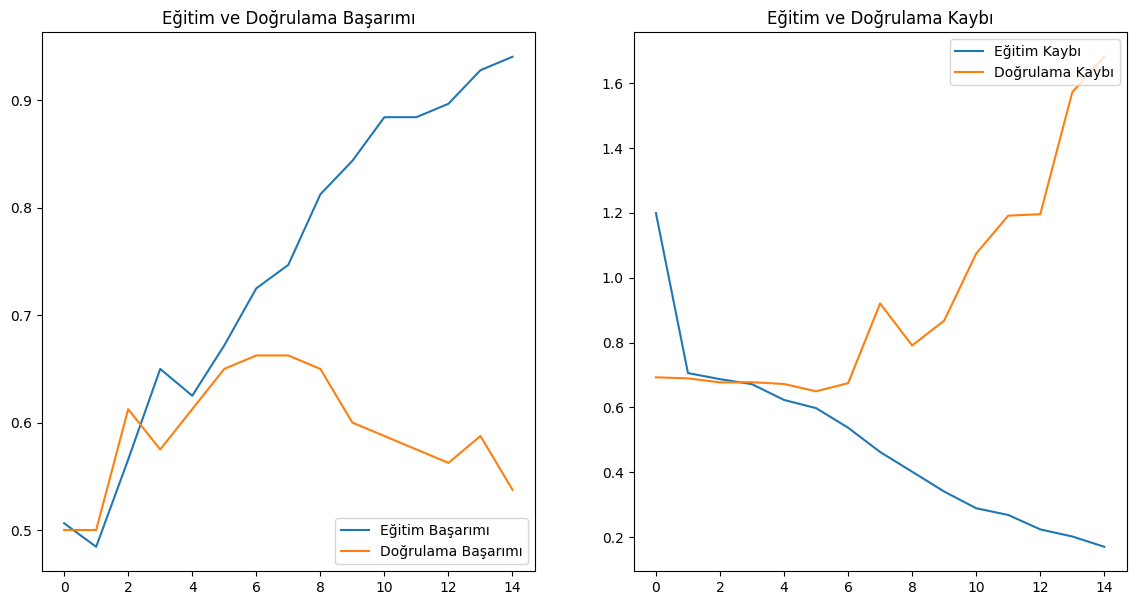

In [4]:
# Veriyi Hazırla, Modeli Kur, Eğit ve Sonuçları Göster

# Adım 1: Veriyi Modele Hazırla
print("Veri, model için hazırlanıyor...")
IMG_WIDTH, IMG_HEIGHT, BATCH_SIZE = 150, 150, 32
base_dir = '/kaggle/working/dataset/'
image_generator = ImageDataGenerator(rescale=1./255, validation_split=0.2)
train_generator = image_generator.flow_from_directory(directory=base_dir, target_size=(IMG_WIDTH, IMG_HEIGHT), batch_size=BATCH_SIZE, class_mode='binary', subset='training')
validation_generator = image_generator.flow_from_directory(directory=base_dir, target_size=(IMG_WIDTH, IMG_HEIGHT), batch_size=BATCH_SIZE, class_mode='binary', subset='validation')
print("-> Veri jeneratörleri hazır.")

# Adım 2: Modeli Oluştur ve Eğit
print("\nModel mimarisi kuruluyor ve eğitim başlatılıyor...")
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)), MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'), MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'), MaxPooling2D(2, 2),
    Flatten(), Dropout(0.5),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()
epochs = 15
history = model.fit(train_generator, epochs=epochs, validation_data=validation_generator)
print("\n--- EĞİTİM BAŞARIYLA TAMAMLANDI! ---")

# Adım 3: Eğitim Sonuçlarını Görselleştir
print("\nEğitim performans grafikleri çiziliyor...")
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(epochs)
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Eğitim Başarımı')
plt.plot(epochs_range, val_acc, label='Doğrulama Başarımı')
plt.legend(loc='lower right')
plt.title('Eğitim ve Doğrulama Başarımı')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Eğitim Kaybı')
plt.plot(epochs_range, val_loss, label='Doğrulama Kaybı')
plt.legend(loc='upper right')
plt.title('Eğitim ve Doğrulama Kaybı')
plt.show()

Test için seçilen resim: /kaggle/working/dataset/hasarli/hasarli_cat.309.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 758ms/step
Tahmin: HASARLI (Skor: 0.08)


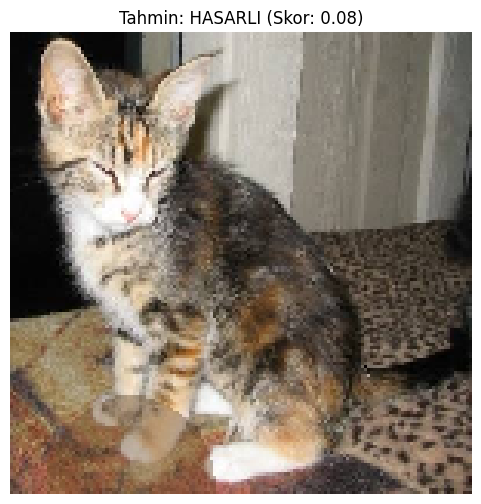

In [5]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Test için 'hasarli' veya 'saglam' klasörünü seçebilirsin
test_klasoru = hasarli_dir 
rastgele_resim = random.choice(os.listdir(test_klasoru))
resim_yolu = os.path.join(test_klasoru, rastgele_resim)

print(f"Test için seçilen resim: {resim_yolu}")

# Resmi modele uygun boyuta getir ve yükle
img = image.load_img(resim_yolu, target_size=(IMG_WIDTH, IMG_HEIGHT))

# Resmi bir sayı dizisine çevir
img_array = image.img_to_array(img)
# Piksel değerlerini 0-1 arasına ölçeklendir
img_array /= 255.0
# Modele tek bir resim göndereceğimizi belirtmek için boyut ekle
img_array = np.expand_dims(img_array, axis=0)

# TAHMİN YAP
tahmin = model.predict(img_array)

if tahmin[0][0] < 0.5:
    sonuc = f"Tahmin: HASARLI (Skor: {tahmin[0][0]:.2f})"
else:
    sonuc = f"Tahmin: SAĞLAM (Skor: {tahmin[0][0]:.2f})"

print(sonuc)

# Sonucu görselleştir
plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.title(sonuc)
plt.axis('off')
plt.show()